In [ ]:
!pip install tensorflow==1.15.0

     |████████████████████████████████| 412.3MB 32kB/s 
     |████████████████████████████████| 3.8MB 19.5MB/s 
     |████████████████████████████████| 512kB 40.9MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=5c4a8a00a3b45cc3f180fefd830cc3cbb97a565389681fd0ae94a5c200d99ba3
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully 

In [ ]:
import os.path
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t

from tqdm import tnrange, tqdm_notebook, tqdm

from IPython.core.display import display

%matplotlib inline

sns.set()
sns.set(font="IPAexGothic")
plt.rcParams['font.family'] = 'Yu Mincho'

# C:\\sample\\nn_linear_regression にデータを読み書きする
WORK_DIR = '/content/drive/My Drive/'

dji = pd.read_csv(
    os.path.join(WORK_DIR, '0.data', 'DJI.csv'), 
    parse_dates=['Date'],
    engine='python'
)

dji = dji.sort_values('Date').reset_index(drop=True)



In [ ]:
dji = dji.assign(LogReturn=np.log(dji.loc[:, 'Adj Close']).diff())
dji = dji.iloc[1:]

In [ ]:
dji.head()

,Date,Open,High,Low,Close,Adj Close,Volume,LogReturn
1,1992-01-06,3201.5,3213.33,3191.86,3200.1,3200.1,272800,-0.000437
2,1992-01-07,3200.1,3210.20,3184.48,3204.8,3204.8,255100,0.001468
3,1992-01-08,3204.8,3229.20,3185.82,3203.9,3203.9,290400,-0.000281
4,1992-01-09,3203.9,3228.31,3192.75,3209.5,3209.5,298200,0.001746
5,1992-01-10,3209.5,3217.13,3185.38,3199.5,3199.5,234400,-0.003121


In [ ]:
batch_size = 8
lookback_size = 64
num_hidden_neurons = 40
num_hidden_layers = 3
learning_rate = 1e-5

In [ ]:
class RecurrentSimulationNet:
    def __init__(
        self, sess, batch_size, lookback_size,
        num_hidden_neurons, num_hidden_layers,
        learning_rate,  momentum=0.9, training=False
    ):
# --- ソースコード4.57 ---
        self._inputs = tf.placeholder(
            tf.float32, [batch_size, lookback_size], name='inputs'
        )
        self._labels = tf.placeholder(
            tf.float32, [batch_size, lookback_size], name='labels'
        )
# --- ソースコード4.57 ここまで ---

# --- ソースコード4.58 ---
        self._inputs_normed = tf.layers.batch_normalization(
            tf.expand_dims(self._inputs, axis=-1),
            momentum=momentum, training=training
        )
                
        with tf.variable_scope('recurrent_part'):
            rnn_cell = tf.nn.rnn_cell.MultiRNNCell(
                [
                    tf.nn.rnn_cell.LSTMCell(num_units=num_hidden_neurons)
                    for _ in range(num_hidden_layers)
                ]
            )
            self._initial_state = rnn_cell.zero_state(batch_size, tf.float32)

            self._rnn_outputs, self._final_state = tf.nn.dynamic_rnn(
                rnn_cell, 
                self._inputs_normed, 
                initial_state=self._initial_state
            )
# --- ソースコード4.58 ここまで ---
# --- ソースコード4.59 ---
        with tf.variable_scope('distribution'):
            self._dist_loc = tf.squeeze(
                tf.layers.dense(self._rnn_outputs, 1), axis=-1
            )
            self._dist_scale = tf.squeeze(
                tf.nn.softplus(tf.layers.dense(self._rnn_outputs, 1)),
                axis=-1
            )
            self._distributions = tf.contrib.distributions.StudentT(
                df=3.0, loc=self._dist_loc, scale=self._dist_scale
            )
# --- ソースコード4.59 ここまで ---
# --- ソースコード4.60 ---
        with tf.variable_scope('outputs'):
            self._dist_sample_size = tf.get_variable(
                'sample_size', (), dtype=tf.int32, trainable=False
            )
            self._dist_sample = self._distributions.sample(
                self._dist_sample_size
            )
            self._log_likelihood = tf.reduce_mean(
                tf.log(
                    self._distributions.prob(self._labels)
                )
            )
            
        update_ops = tf.get_collection(
            tf.GraphKeys.UPDATE_OPS
        )
        with tf.control_dependencies(update_ops):
            self._training_step = tf.train.AdamOptimizer(
                learning_rate
            ).minimize(
                -self._log_likelihood
            )
    
        self.ssn_saver = tf.train.Saver()    
        if training:
            sess.run(
                tf.global_variables_initializer()
            )
# --- ソースコード4.60 ここまで ---
# --- ソースコード4.61 ---
    def train_one_step(
        self, sess, prev_samples, target_samples, state=None
    ):
        fetches = [
            self._training_step,
            self._log_likelihood,
            self._final_state
        ]
        feed_dict = {
            self._inputs: prev_samples,
            self._labels: target_samples
        }
        if state is not None:
            feed_dict = {
                **feed_dict,
                self._initial_state: state
            }
        return sess.run(
            fetches=fetches, feed_dict=feed_dict
        )
# --- ソースコード4.61 ここまで ---
    
    def sample(
        self, sess, prev_samples, sample_size=1, state=None
    ):
        fetches = [
            self._dist_sample,
            self._final_state
        ]
        feed_dict = {
            self._inputs: prev_samples,
            self._dist_sample_size: sample_size
        }
        if state is not None:
            feed_dict = {
                **feed_dict,
                self._initial_state: state
            }
        return sess.run(fetches=fetches, feed_dict=feed_dict)    
    
    def save(self, sess, path):
        self.ssn_saver.save(sess, path)
        print(f'model saved in {path}')
        
    def restore(self, sess, path):
        self.ssn_saver.restore(sess, path)


In [ ]:
max_epochs = 100
steps_per_epoch = 50

In [ ]:
likelihoods_over_time = np.empty(max_epochs)
tf.reset_default_graph()

with tf.Graph().as_default() and tf.Session() as session:
    rec_sim_net = RecurrentSimulationNet(
        session, batch_size, lookback_size,
        num_hidden_neurons, num_hidden_layers,
        learning_rate, training=True
    )
    for epoch in range(max_epochs):
        random_row_indices = np.random.choice(
            dji.shape[0] - lookback_size * (steps_per_epoch+1) - 1,
            size=batch_size,
            replace=True
        )
        random_rows = [
            dji.iloc[
                random_row:random_row + lookback_size*(steps_per_epoch+1),
                :
            ]
            for random_row in random_row_indices
        ]
        log_returns_for_this_epoch = np.reshape(
            [row[['LogReturn']].values for row in random_rows],
            (batch_size, lookback_size*(steps_per_epoch + 1))
        )
        state = None
        likelihood_mean_epoch = 0.
        
        for training_step in range(steps_per_epoch):
            _, log_likelihood, state = rec_sim_net.train_one_step(
                session,
                log_returns_for_this_epoch[
                    :,
                    lookback_size*training_step:lookback_size*(training_step + 1)
                ],
                log_returns_for_this_epoch[
                    :,
                    lookback_size*training_step + 1:lookback_size*(training_step + 1) + 1
                ],
                state=state
            )
            likelihood_mean_epoch += log_likelihood
        likelihoods_over_time[epoch] = likelihood_mean_epoch / steps_per_epoch
        likelihood_mean_polling_interval = 0.
        print(
            f'[{(100*epoch) // max_epochs:3}%] '
            f'直近{steps_per_epoch}ステップの平均尤度：'
            f'{likelihoods_over_time[epoch]:.5f}'
        )
    rec_sim_net.save(
        session, os.path.join(
            WORK_DIR,
            'models',
            'recurrent_simulation_net'
        )
    )
likelihoods_over_time_copy = likelihoods_over_time.copy()

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.Dense instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, p

findfont: Font family ['Yu Mincho'] not found. Falling back to DejaVu Sans.


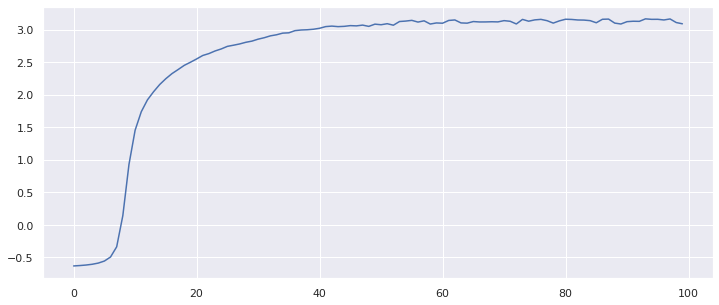

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(
    x=list(range(likelihoods_over_time.shape[0])),
    y=likelihoods_over_time,
    ax=ax
)